In [1]:
import numpy as np
from driving.env import *
from matplotlib import pyplot as plt
import random
from ipywidgets import interactive

In [2]:
oval = make_oval()
env = DrivingEnv(dt=0.5)

def policy(s):
    d, a = oval.distance_angle_deg(s[0], s[1], s[2])
    if random.random() < 0.6:
       return 60.0*(random.random()-0.5)
    return -100*d - 2*a + 30.0*np.random.normal()
    # return 0.0

In [3]:
def sim(policy, n_steps=1000):
    env = DrivingEnv()
    s = env.reset()
    history = []
    for i in range(1000):
        a = policy(s)
        sp, r, done, info = env.step(a)
        history.append((s, a, r, sp))
        s = sp
    return history

def showmodel(model, theta=0.0, a=0.0):
    N = 20

    x = np.linspace(-1.0, 4.0, N)
    y = np.linspace(-1.0, 3.0, N)
    X, Y = np.meshgrid(x, y)
    Z = np.empty(X.shape)
    sa = np.empty((Z.size, 4))
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            x = X[i,j]
            y = Y[i,j]
            sa[i*Z.shape[1]+j, :] = np.array((x, y, theta, a))

    qs = np.clip(model.predict(sa), -100.0, 0.0)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i,j] = qs[i*Z.shape[1]+j].item()

    plt.contourf(X,Y,Z)
    plt.colorbar()

In [4]:
history = sim(policy)

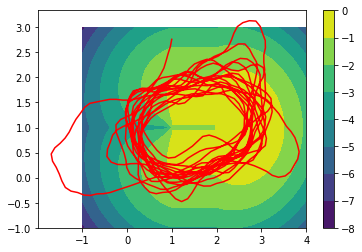

In [5]:
N = 100
x = np.linspace(-1.0, 4.0, N)
y = np.linspace(-1.0, 3.0, N)
X, Y = np.meshgrid(x, y)
Z = np.empty(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        x = X[i,j]
        y = Y[i,j]
        # d, a = oval.distance_angle(x, y, 0.0)
        r = env.reward(np.array((x,y,90.0)), 0.0)
        Z[i,j] = r
plt.contourf(X,Y,Z)
xs = [step[0][0] for step in history]
ys = [step[0][1] for step in history]
plt.plot(xs, ys, color='red')
plt.colorbar()

In [6]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=4))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.
W0812 15:29:55.747734 139821397862208 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 15:29:55.763677 139821397862208 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 15:29:55.765919 139821397862208 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 15:29:55.791412 139821397862208 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random

In [7]:
deg_factor = 1/180

for k in range(3):
    sa_buffer = np.zeros(shape=(0,4))
    r_buffer = []
    for i in range(50):
        history = sim(policy)
        for step in history:
            sa = np.concatenate((step[0], (step[1],)))
            sa_buffer = np.vstack((sa_buffer, sa*(1.0, 1.0, deg_factor, deg_factor)))
            r_buffer.append(step[2])
    r_array = np.reshape(np.array(r_buffer), (len(r_buffer),1))
    model.fit(sa_buffer, r_array, epochs=5, batch_size=32, shuffle=True)

W0812 15:30:11.562540 139821397862208 deprecation_wrapper.py:119] From /home/zach/anaconda3/envs/ai4all/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/5
50000/50000 [==============================] - 4s 78us/step - loss: 0.2777
Epoch 2/5
50000/50000 [==============================] - 3s 64us/step - loss: 0.0368
Epoch 3/5
50000/50000 [==============================] - 4s 78us/step - loss: 0.0230
Epoch 4/5
50000/50000 [==============================] - 4s 73us/step - loss: 0.0175
Epoch 5/5
50000/50000 [==============================] - 4s 82us/step - loss: 0.0132
Epoch 1/5
50000/50000 [==============================] - 4s 74us/step - loss: 0.1241
Epoch 2/5
50000/50000 [==============================] - 4s 76us/step - loss: 0.0447
Epoch 3/5
50000/50000 [==============================] - 4s 89us/step - loss: 0.0500
Epoch 4/5
50000/50000 [==============================] - 5s 94us/step - loss: 0.0427
Epoch 5/5
50000/50000 [==============================] - 4s 88us/step - loss: 0.0344
Epoch 1/5
50000/50000 [==============================] - 4s 83us/step - loss: 0.0090
Epoch 2/5
50000/50000 [==============================] - 5s 92us/

In [108]:
model.predict(np.array([[1.0, 0.5, 0.0, -15.0*deg_factor]]))

array([[-1.0731428]], dtype=float32)

In [109]:
interactive(lambda theta, a: showmodel(model, theta, a), theta=(0,360), a=(-30.0, 30.0))

interactive(children=(FloatSlider(value=1.0, description='theta', max=2.0), FloatSlider(value=0.0, description…